# Introduction

Reflexion [@shinn2023reflexion] is a method that allows an AI agent to learn and improve by reflecting on past failures, like humans do. The agent reflects on internal and external feedback, which could be scalar or free-form text. The resulting reflective text is kept as long-term memory. The approach, like self-refine [@madaan2023selfrefine], also requires a strong model.

<p style="text-align:center;">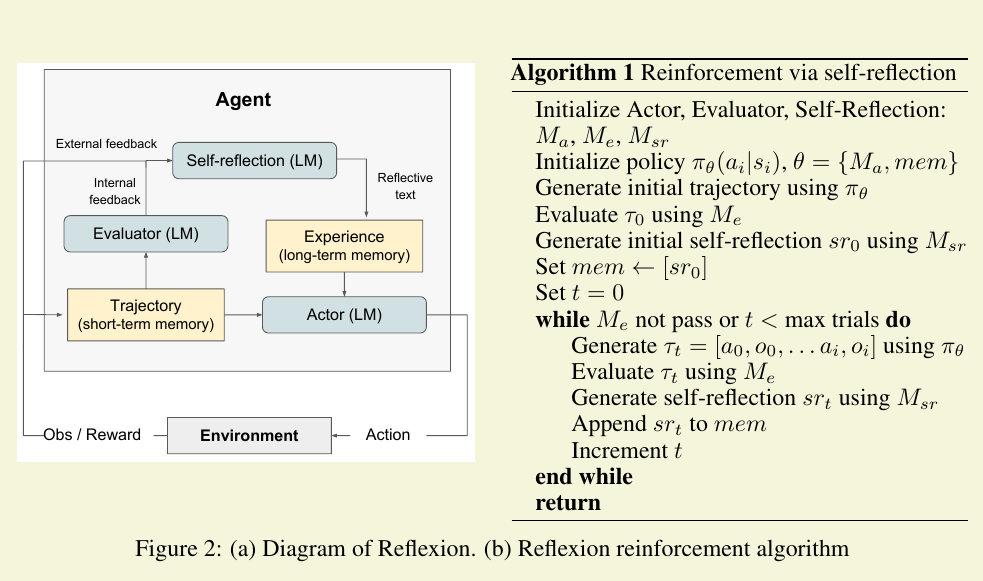<br>
Source: Shinn et al. [@shinn2023reflexion]
</p>

Reflextion consists of four main components:

- Actor: a model to generate text and actions
- Evaluator: a model to score the outputs by the actor
    - could use pre-defined heuristic functions or reward functions.
- Self-reflection model: generate self-reflective feedback
- Memory: keeps short-term and long-term memories.
    - short-term memory: trajectory history
    - long-term memory: reflective text

Its pipeline can be summarized as:

>Task -> Trajectory -> Evaluation -> Reflection -> Next Trajectory

This notebook tries ReAct + Reflexion to solve a reasoning problem by using Gemini 1.5.

# Implement a Reflexion agent

In [1]:
#| code-fold: true
#| code-summary: show import statements

import os
import re
import string
import time
import wikipedia

import google.generativeai as genai
from google.generativeai import GenerativeModel

import sys
sys.path.append('../src')
import utils

from dotenv import load_dotenv
load_dotenv();

The prompts are adapted from the authors' [prompts.py](https://github.com/noahshinn/reflexion/blob/main/hotpotqa_runs/prompts.py).
Few-shot examples are copied from the authors' [fewshots.py](https://github.com/noahshinn/reflexion/blob/main/hotpotqa_runs/fewshots.py).

In [31]:
#| code-fold: true
#| code-summary: Click to show prompts and few-shot examples

REACT_PROMPT = """
Solve a question answering task with interleaving Thought, Action, Observation steps. \
Thought can reason about the current situation, and Action can be three types: 
(1) Search[title], which searches the exact title on Wikipedia and returns the first \
paragraph if it exists. If not, it will return some similar titles to search.
(2) Lookup[keyword], which returns the next paragraph containing the keyword from the \
wikipedia page successfully found by Search.
(3) Finish[answer], which returns the answer and finishes the task.
You may take as many steps as necessary. Remember use Finish[answer] as your action if you have an answer.

Here are some examples:

{examples}

(END OF EXAMPLES)
{reflections}
Question: {question}{generation_prompt}
""".strip()

REFLECTION_PROMPT = """
You are an advanced reasoning agent that can improve based on self reflection. \
You will be given a previous reasoning trial in which you were given access to an \
Docstore API environment and a question to answer. You were unsuccessful in answering \
the question either because you guessed the wrong answer with Finish[<answer>], \
or you used up your set number of reasoning steps. In a few sentences, diagnose \
a possible reason for failure and devise a new, concise, high level plan that aims to \
mitigate the same failure. Use complete sentences.
Here are some examples:

{examples}

Now it's your turn to reflect on the previous trail that was failed.

Previous Trial:
Question: {question}{generation_prompt}

Reflection:
""".strip()

REACT_EXAMPLES = """
Question: What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?
Thought 1: I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.
Action 1: Search[Colorado orogeny]
Observation 1: The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.
Thought 2: It does not mention the eastern sector. So I need to look up eastern sector.
Action 2: Lookup[eastern sector]
Observation 2: (Result 1 / 1) The eastern sector extends into the High Plains and is called the Central Plains orogeny.
Thought 3: The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.
Action 3: Search[High Plains]
Observation 3: High Plains refers to one of two distinct land regions:
Thought 4: I need to instead search High Plains (United States).
Action 4: Search[High Plains (United States)]
Observation 4: The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130 m).[3]
Thought 5: High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.
Action 5: Finish[1,800 to 7,000 ft]

Question: Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?
Thought 1: The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.
Action 1: Search[Milhouse]
Observation 1: Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.
Thought 2: The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".
Action 2: Lookup[named after]
Observation 2: (Result 1 / 1) Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous. 
Thought 3: Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.
Action 3: Finish[Richard Nixon]

Question: Which documentary is about Finnish rock groups, Adam Clayton Powell or The Saimaa Gesture?
Thought 1: I need to search Adam Clayton Powell and The Saimaa Gesture, and find which documentary is about Finnish rock groups.
Action 1: Search[Adam Clayton Powell]
Observation 1: Could not find [Adam Clayton Powell]. Similar: ['Adam Clayton Powell III', 'Seventh Avenue (Manhattan)', 'Adam Clayton Powell Jr. State Office Building', 'Isabel Washington Powell', 'Adam Powell', 'Adam Clayton Powell (film)', 'Giancarlo Esposito'].
Thought 2: To find the documentary, I can search Adam Clayton Powell (film).
Action 2: Search[Adam Clayton Powell (film)]
Observation 2: Adam Clayton Powell is a 1989 American documentary film directed by Richard Kilberg.
The film is about the rise and fall of influential African-American politician Adam Clayton Powell Jr.[3][4] It was later aired as part of the PBS series The American Experience.
Thought 3: Adam Clayton Powell (film) is a documentary about an African-American politician, not Finnish rock groups. So the documentary about Finnish rock groups must instead be The Saimaa Gesture.
Action 3: Finish[The Saimaa Gesture]

Question: What profession does Nicholas Ray and Elia Kazan have in common?
Thought 1: I need to search Nicholas Ray and Elia Kazan, find their professions, then find the profession they have in common.
Action 1: Search[Nicholas Ray]
Observation 1: Nicholas Ray (born Raymond Nicholas Kienzle Jr., August 7, 1911 – June 16, 1979) was an American film director, screenwriter, and actor best known for the 1955 film Rebel Without a Cause.
Thought 2: Professions of Nicholas Ray are director, screenwriter, and actor. I need to search Elia Kazan next and find his professions.
Action 2: Search[Elia Kazan]
Observation 2: Elia Kazan was an American film and theatre director, producer, screenwriter and actor.
Thought 3: Professions of Elia Kazan are director, producer, screenwriter, and actor. So profession Nicholas Ray and Elia Kazan have in common is director, screenwriter, and actor.
Action 3: Finish[director, screenwriter, actor]

Question: Which magazine was started first Arthur's Magazine or First for Women?
Thought 1: I need to search Arthur's Magazine and First for Women, and find which was started first.
Action 1: Search[Arthur's Magazine]
Observation 1: Arthur's Magazine (1844-1846) was an American literary periodical published in Philadelphia in the 19th century. 
Thought 2: Arthur's Magazine was started in 1844. I need to search First for Women next.
Action 2: Search[First for Women]
Observation 2: First for Women is a woman's magazine published by Bauer Media Group in the USA.[1] The magazine was started in 1989. 
Thought 3: First for Women was started in 1989. 1844 (Arthur's Magazine) < 1989 (First for Women), so Arthur's Magazine was started first.
Action 3: Finish[Arthur's Magazine]

Question: Were Pavel Urysohn and Leonid Levin known for the same type of work?
Thought 1: I need to search Pavel Urysohn and Leonid Levin, find their types of work, then find if they are the same.
Action 1: Search[Pavel Urysohn]
Observation 1: Pavel Samuilovich Urysohn (February 3, 1898 â August 17, 1924) was a Soviet mathematician who is best known for his contributions in dimension theory.
Thought 2: Pavel Urysohn is a mathematician. I need to search Leonid Levin next and find its type of work.
Action 2: Search[Leonid Levin]
Observation 2: Leonid Anatolievich Levin is a Soviet-American mathematician and computer scientist. 
Thought 3: Leonid Levin is a mathematician and computer scientist. So Pavel Urysohn and Leonid Levin have the same type of work. 
Action 3: Finish[yes]
""".strip()

REFLECTION_EXAMPLES = """
Previous Trial:
Question: The Rome Protocols were signed by three Prime Ministers one of which was assassinated as part of what?
Thought 1: I need to search Rome Protocols, find the three Prime Ministers, then find what they were assassinated as part of.
Action 1: Search[Rome Protocols]
Observation 1: The Rome Protocols were a series of three international agreements concluded in Rome on 17 March 1934 between the governments of Austria, Hungary and Italy. They were signed by Italian Prime Minister Benito Mussolini, Austrian Chancellor Engelbert Dollfuss and Hungarian Prime Minister Gyula Gömbös. All of the protocols went into effect on 12 July 1934 and were registered in League of Nations Treaty Series on 12 December 1934.
Thought 2: The three Prime Ministers were Benito Mussolini, Engelbert Dollfuss, and Gyula Gömbös. I need to search Benito Mussolini and find what he was assassinated as part of.
Action 2: Search[Benito Mussolini]
Observation 2: Benito Amilcare Andrea Mussolini (UK:  MU(U)SS-ə-LEE-nee, US:  MOOSS-, Italian: [beˈniːto aˈmilkare anˈdrɛːa mussoˈliːni]; 29 July 1883 – 28 April 1945) was an Italian politician and journalist who founded and led the National Fascist Party (PNF). He was Prime Minister of Italy from the March on Rome in 1922 until his deposition in 1943, as well as "Duce" of Italian fascism from the establishment of the Italian Fasces of Combat in 1919 until his summary execution in 1945 by Italian partisans. As dictator of Italy and principal founder of fascism, Mussolini inspired and supported the international spread of fascist movements during the inter-war period.Mussolini was originally a socialist politician and a journalist at the Avanti! newspaper. In 1912, he became a member of the National Directorate of the Italian Socialist Party (PSI), but he was expelled from the PSI for advocating military intervention in World War I, in opposition to the party's stance on neutrality. In 1914, Mussolini founded a new journal, Il Popolo d'Italia, and served in the Royal Italian Army during the war until he was wounded and discharged in 1917. Mussolini denounced the PSI, his views now centering on Italian nationalism instead of socialism, and later founded the fascist movement which came to oppose egalitarianism and class conflict, instead advocating "revolutionary nationalism" transcending class lines. On 31 October 1922, following the March on Rome (28–30 October), Mussolini was appointed prime minister by King Victor Emmanuel III, becoming the youngest individual to hold the office up to that time. After removing all political opposition through his secret police and outlawing labor strikes, Mussolini and his followers consolidated power through a series of laws that transformed the nation into a one-party dictatorship. Within five years, Mussolini had established dictatorial authority by both legal and illegal means and aspired to create a totalitarian state. In 1929, Mussolini signed the Lateran Treaty with the Holy See to establish Vatican City.
Mussolini's foreign policy aimed to restore the ancient grandeur of the Roman Empire by expanding Italian colonial possessions and the fascist sphere of influence. In the 1920s, he ordered the Pacification of Libya, instructed the bombing of Corfu over an incident with Greece, established a protectorate over Albania, and incorporated the city of Fiume into the Italian state via agreements with Yugoslavia. In 1936, Ethiopia was conquered following the Second Italo-Ethiopian War and merged into Italian East Africa (AOI) with Eritrea and Somalia. In 1939, Italian forces annexed Albania. Between 1936 and 1939, Mussolini ordered the successful Italian military intervention in Spain in favor of Francisco Franco during the Spanish Civil War. Mussolini's Italy initially tried to avoid the outbreak of a second global war, sending troops at the Brenner Pass to delay Anschluss and taking part in the Stresa Front, the Lytton Report, the Treaty of Lausanne, the Four-Power Pact and the Munich Agreement. However, Italy then alienated itself from Britain and France by aligning with Germany and Japan. Germany invaded Poland on 1 September 1939, resulting in declarations of war by France and the UK and the start of World War II.
On 10 June 1940, Mussolini decided to enter the war on the Axis side. Despite initial success, the subsequent Axis collapse on multiple fronts and eventual Allied invasion of Sicily made Mussolini lose the support of the population and members of the Fascist Party. As a consequence, early on 25 July 1943, the Grand Council of Fascism passed a motion of no confidence in Mussolini; later that day King Victor Emmanuel III dismissed him as head of government and had him placed in custody, appointing Pietro Badoglio to succeed him as Prime Minister. After the king agreed to an armistice with the Allies, on 12 September 1943 Mussolini was rescued from captivity in the Gran Sasso raid by German paratroopers and Waffen-SS commandos led by Major Otto-Harald Mors. Adolf Hitler, after meeting with the rescued former dictator, then put Mussolini in charge of a puppet regime in northern Italy, the Italian Social Republic (Italian: Repubblica Sociale Italiana, RSI), informally known as the Salò Republic, causing a civil war. In late April 1945, in the wake of near total defeat, Mussolini and his mistress Clara Petacci attempted to flee to Switzerland, but both were captured by Italian communist partisans and summarily executed by firing squad on 28 April 1945 near Lake Como. The bodies of Mussolini and his mistress were then taken to Milan, where they were hung upside down at a service station to publicly confirm their demise.
Thought 3: Benito Mussolini was assassinated as part of the collapse of the Axis powers during World War II. So the Rome Protocols were signed by three Prime Ministers one of which was assassinated as part of World War II.
Action 3: Finish[World War II]

Reflection: I searched one of the prime ministers involved in the signing, then attemted to answer right away. I should have searched each of the prime ministers, then looked up 'death' on each of their pages in order to get more information before answering.

Previous Trial:
Question: Kam Heskin plays Paige Morgan in a 2004 film directed by who?
Thought 1: I need to search Kam Heskin and Paige Morgan, find the 2004 film they are in, then find the director of the film.
Action 1: Search[Kam Heskin]
Observation 1: Kam Erika Heskin (born May 8, 1973) is an American actress. She began her career playing Caitlin Deschanel on the NBC daytime soap opera Sunset Beach (1998–1999), before appearing in films Planet of the Apes (2001) and Catch Me If You Can (2002). Heskin went on in 2003 to play Elizabeth Bennet in an independent film Pride & Prejudice: A Latter-Day Comedy, Robin in Charmed (2004),  and Paige Morgan in The Prince and Me film franchise (2006–2010).
Thought 2: Kam Heskin plays Paige Morgan in The Prince and Me film franchise. I need to search The Prince and Me film franchise and find the director of the 2004 film.
Action 2: Search[The Prince and Me film franchise]
Observation 2: Could not find [The Prince and Me film franchise]. Similar: ['Kam Heskin', 'Prince of Persia', 'Harry Potter and the Half-Blood Prince (film)', 'Prince of Persia: The Sands of Time (film)', 'The Chronicles of Narnia (film series)', 'Majestic Prince (franchise)', 'Kingsman (franchise)', 'The Little Prince (2015 film)', 'Shrek (franchise)', 'Harry Potter (film series)']
Thought 3: I need to search The Prince and Me (2004 film) instead.
Action 3: Search[The Prince and Me (2004 film)]
Observation 3: Could not find [The Prince and Me (2004 film)]. Similar: ['The Prince & Me', 'The Prince & Me 2: The Royal Wedding', 'Kam Heskin', 'Prince of Darkness (film)', 'Prince of Persia: The Sands of Time (film)', 'Rob Knox', 'Alexander (2004 film)', 'Prince of Persia', 'Brooklynn Prince', 'Prince (musician)']
Thought 4: I need to search The Prince & Me (2004 film).
Action 4: Search[The Prince & Me (2004 film)]
Observation 4: Could not find [The Prince & Me (2004 film)]. Similar: ['The Prince & Me', 'The Prince & Me 2: The Royal Wedding', 'Prince of Darkness (film)', 'Prince of Persia: The Sands of Time (film)', 'Rob Knox', 'Alexander (2004 film)', 'Prince (musician)', 'Prince of Persia', 'Kam Heskin', 'Brooklynn Prince']
Thought 5: I need to search The Prince & Me (2004 film) instead.
Action 5: Search[The Prince & Me (2004 film)]
Observation 5: Could not find [The Prince & Me (2004 film)]. Similar: ['The Prince & Me', 'The Prince & Me 2: The Royal Wedding', 'Prince of Darkness (film)', 'Prince of Persia: The Sands of Time (film)', 'Rob Knox', 'Alexander (2004 film)', 'Prince (musician)', 'Prince of Persia', 'Kam Heskin', 'Brooklynn Prince']
Thought 6: I need to search The Prince & Me (2004 film).
Action 6: Search[The Prince & Me (2004 film)]
Observation 6: Could not find [The Prince & Me (2004 film)]. Similar: ['The Prince & Me', 'The Prince & Me 2: The Royal Wedding', 'Prince of Darkness (film)', 'Prince of Persia: The Sands of Time (film)', 'Rob Knox', 'Alexander (2004 film)', 'Prince (musician)', 'Prince of Persia', 'Kam Heskin', 'Brooklynn Prince']

Reflection: I got stuck in a loop where I kept trying to search 'The Prince & Me (2004 film)' but the page could not be found. Instead I should have tried to search the similar results that had a similar name to see and they were made in 2004.
""".strip()

Next, create a docstore that searches Wikipedia by title. It also allows an agent to look up keywords in a wikipedia page returned by search.

In [3]:
#| code-fold: true
#| code-summary: Click to show code for WikipediaDocStore

class WikipediaDocStore:
    def __init__(self) -> None:
        self.lookup_index = 0
        self.chunks: list[str] = []

    def search_page(self, title: str) -> str:
        # reset keyword lookup index of paragraphs
        default_error_msg = 'Unable to find any useful page. Choose an alternative title to search.'
        self.lookup_index = 0
        try:
            page_content = wikipedia.page(title).content
            # split page content into paragraphs
            chunks = page_content.split('\n')
            self.chunks = [c.strip() for c in chunks if len(c.strip()) > 0]
            if self.chunks:
                return self.chunks[0]
            else:
                return default_error_msg
        except:
            alt_titles = wikipedia.search(title)
            alt_titles = map(lambda x: x.strip(), alt_titles)
            alt_titles = filter(lambda x: len(x)>0, alt_titles)
            alt_titles = '\n- '.join(alt_titles)
            if alt_titles:
                error_message = (
                    "Unable to find a page with the given title. "
                    f"The following is a list of similar titles:\n- {alt_titles}"
                )
            else:
                error_message = default_error_msg
            return error_message

    def lookup_chunk(self, keyword: str) -> str:
        self.lookup_index += 1
        for i in range(self.lookup_index, len(self.chunks)):
            if keyword.lower() in self.chunks[i].lower():
                return self.chunks[i]
        return "The page doesn't contain the keyword."
                # "Please try to search an alternative wikipedia page."

Finally, create a Reflexion agent. It first tries to answer a question using ReAct prompting. If failed, it'll reflect on the last trial and then try again with the reflection(s) as guidance.

In [4]:
#| code-fold: true
#| code-summary: Click to show code for ReflexionAgent

class ReflexionAgent:
    """An agent uses ReAct prompting and reflection to answer user questions.
    It will search Wikipedia to help answer questions.
    """

    def __init__(self, llm_react: GenerativeModel, llm_reflect: GenerativeModel, throttle: int = 0) -> None:
        self._llm_react = llm_react
        self._llm_reflect = llm_reflect
        self.throttle = throttle
        self.docstore = WikipediaDocStore()

        self.react_prompt = REACT_PROMPT
        self.react_examples = REACT_EXAMPLES
        self.reflection_prompt = REFLECTION_PROMPT
        self.reflection_examples = REFLECTION_EXAMPLES

        self._last_react_prompt = None
        self._last_reflect_prompt = None

    def run(self, question: str, target: str, n_react_steps: int = 6, n_attempts: int = 5) -> None:
        self.question = question
        self.target = target
        self.reflections: list[str] = []
        self.n_react_steps = n_react_steps

        for _ in range(n_attempts):
            # run ReAct prompting
            self.answer = None
            self.run_react()
            if self._is_answer_correct():
                break

            # run reflection prompting
            self.run_reflection()

    def run_react(self) -> None:
        self._reset_react()
        while self.current_step <= self.n_react_steps and not self.finished:
            self._step()

    def run_reflection(self):
        start_time = time.perf_counter()
        prompt = self.reflection_prompt.format(
            examples=self.reflection_examples,
            question=self.question,
            generation_prompt=self.generation_prompt)
        self._last_reflect_prompt = prompt
        
        output, reflection_output = self._ask_llm(prompt, 'Reflection:', 'reflect')
        reflection_output = re.sub(r'\n+', ' ', reflection_output)
        self.reflections.append(reflection_output)

        print(f'{"-"*20} DEBUG: reflection {"-"*20}')
        print(output)
        print(f'{"-"*59}')

        utils.throttle(start_time, self.throttle)

    def _reset_react(self) -> None:
        self.current_step = 1
        self.finished = False
        self.generation_prompt = ''

    def _step(self) -> None:
        formatted_reflections = self._format_reflections()

        # think
        think_prefix = f'Thought {self.current_step}:'
        self.generation_prompt += f'\n{think_prefix} '

        prompt = self.react_prompt.format(
            examples=self.react_examples,
            reflections=formatted_reflections,
            question=self.question,
            generation_prompt=self.generation_prompt
        )
        start_time = time.perf_counter()
        output, think_output = self._ask_llm(prompt, think_prefix, 'react')
        self.generation_prompt += think_output

        print(f'{"-"*20} DEBUG: ReAct step {self.current_step} {"-"*20}')
        print(think_prefix + ' ' + think_output)
        utils.throttle(start_time, self.throttle)

        # act
        act_prefix = f'Action {self.current_step}:'
        self.generation_prompt += f'\n{act_prefix} '

        prompt = self.react_prompt.format(
            examples=self.react_examples,
            reflections=formatted_reflections,
            question=self.question,
            generation_prompt=self.generation_prompt
        )
        self._last_react_prompt = prompt
        start_time = time.perf_counter()
        output, act_output = self._ask_llm(prompt, act_prefix, 'react')
        self.generation_prompt += act_output
        action, argument = self._parse_action(act_output)
        
        print(act_prefix + ' ' + act_output)

        # observe
        observe_prefix = f'Observation {self.current_step}:'
        self.generation_prompt += f'\n{observe_prefix} '
        if action is None or argument is None:
            self.generation_prompt += 'Invalid Action. Valid Actions are Search[<title>] Lookup[<keyword>] and Finish[<answer>].'
        else:
            if action.lower() == 'finish':
                self.answer = argument
                self.generation_prompt += argument
                self.finished = True
            elif action.lower() == 'search':
                self.generation_prompt += self.docstore.search_page(argument)
            elif action.lower() == 'lookup':
                self.generation_prompt += self.docstore.lookup_chunk(argument)
            else:
                self.generation_prompt += 'Invalid Action. Valid Actions are Search[<title>] Lookup[<keyword>] and Finish[<answer>].'

        self.current_step += 1

        print(observe_prefix + self.generation_prompt.split(observe_prefix)[-1])
        print(f'{"-"*61}')
        utils.throttle(start_time, self.throttle)

    def _ask_llm(self, prompt, prefix, prompt_type):
        try:
            if prompt_type == 'react':
                output = self._llm_react.generate_content(prompt).text.strip()
            else:
                output = self._llm_reflect.generate_content(prompt).text.strip()
            prefix_removed = self._remove_prefix_if_exist(prefix, output)
        except Exception as e:
            print(f'>>>Error from Gemini: {str(e)}')
            output = 'None'
            prefix_removed = 'None'
        return output, prefix_removed
    
    def _format_reflections(self) -> str:
        if not self.reflections:
            return ''

        reflections_str = '\n- '.join(self.reflections)
        formatted_reflections = f"""
You have attempted but failed to answer the following question previously. \
The following reflection(s) give you a plan to avoid making the same mistakes you did previously. \
Use them to improve your strategy of correctly answering the given question.

Reflection(s):
- {reflections_str}\n"""

        return formatted_reflections

    def _is_answer_correct(self):
        if not self.answer:
            return False

        def _normalize_text(text):
            """convert string to lower case, remove punctuations, articles and extra whitespaces."""
            text = text.lower()
            # remove punctuation
            text = text.translate(str.maketrans('', '', string.punctuation))
            # remove articles
            text = re.sub(r'\b(a|an|the)\b', '', text)
            # remove extra whitespaces
            text = re.sub(r'\s+', ' ', text)
            return text

        # if the answer contains the target, it's considered correct.
        return _normalize_text(self.target) in _normalize_text(self.answer)

    @staticmethod
    def _parse_action(string):
        if string is None:
            return None, None
    
        # remove extra chars after ']'
        try:
            idx = string.rindex(']')
            if idx < len(string) -1:
                string = string[:idx+1]
        except:
            pass
    
        match = re.match(r'^(\w+)\[(.+)\]$', string)
        if match:
            action = match.group(1)
            argument = match.group(2)
            return action.strip(), argument.strip()
        else:
            return None, None

    @staticmethod
    def _remove_prefix_if_exist(prefix, text):
        prefix = prefix.lower()
        if prefix in text.lower():
            start_idx = text.lower().index(prefix) + len(prefix)
            text = text[start_idx:].strip()
        return text

# Experiments: solve a HotPotQA question

Define a function to initialize Gemini models. For the experiments, safety settings are disabled so that the model will always provide a response.

In [5]:
# a help function to create models
def init_llms(model_name: str) -> tuple[GenerativeModel, GenerativeModel]:
    genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
    safe = [
        {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
        {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
        {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
        {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"}
    ]    
    llm_react = genai.GenerativeModel(
        model_name,
        safety_settings=safe,
        generation_config={'temperature': 0.0, 'max_output_tokens': 128, "stop_sequences": ["\n"]}
    )
    
    llm_reflect = genai.GenerativeModel(
        model_name,
        safety_settings=safe,
        generation_config={'temperature': 0.0, 'max_output_tokens': 256}
    )
    return llm_react, llm_reflect

Pick a QA pair from HotPotQA dataset for reasoning. It's the 6th row from the authors' data file [hotpot-qa-distractor-sample.joblib](https://github.com/noahshinn/reflexion/blob/main/hotpotqa_runs/data/hotpot-qa-distractor-sample.joblib)

In [6]:
question="The Rome Protocols were signed by three Prime Ministers one of which was assassinated as part of what?"
target="a failed coup attempt"

## Expt. #1: use `gemini-1.5-flash`

In [63]:
llm_react, llm_reflect = init_llms('gemini-1.5-flash-001')
agent_gemini_flash = ReflexionAgent(llm_react, llm_reflect)

agent_gemini_flash.run(question, target)

-------------------- DEBUG: ReAct step 1 --------------------
Thought 1: I need to search Rome Protocols and find the three Prime Ministers who signed it, then find which one was assassinated and what it was part of.
Action 1: Search[Rome Protocols]
Observation 1: The Rome Protocols (German: Römer Protokolle, Hungarian: Római jegyzőkönyvek) were a series of three international agreements concluded in Rome on 17 March 1934 between the governments of Austria, Hungary, and Italy. They were signed by Italian Prime Minister Benito Mussolini, Austrian Chancellor Engelbert Dollfuss, and Hungarian Prime Minister Gyula Gömbös. All of the protocols went into effect on 12 July 1934 and were registered in League of Nations Treaty Series on 12 December 1934.
-------------------------------------------------------------
-------------------- DEBUG: ReAct step 2 --------------------
Thought 2: The Rome Protocols were signed by Benito Mussolini, Engelbert Dollfuss, and Gyula Gömbös. I need to find whic

In [64]:
agent_gemini_flash._is_answer_correct()

True

In [65]:
agent_gemini_flash.answer

'a failed coup attempt by Austrian Nazi agents'

In [66]:
print(agent_gemini_flash._last_reflect_prompt)

You are an advanced reasoning agent that can improve based on self reflection. You will be given a previous reasoning trial in which you were given access to an Docstore API environment and a question to answer. You were unsuccessful in answering the question either because you guessed the wrong answer with Finish[<answer>], or you used up your set number of reasoning steps. In a few sentences, diagnose a possible reason for failure and devise a new, concise, high level plan that aims to mitigate the same failure. Use complete sentences.
Here are some examples:

Previous Trial:
Question: The Rome Protocols were signed by three Prime Ministers one of which was assassinated as part of what?
Thought 1: I need to search Rome Protocols, find the three Prime Ministers, then find what they were assassinated as part of.
Action 1: Search[Rome Protocols]
Observation 1: The Rome Protocols were a series of three international agreements concluded in Rome on 17 March 1934 between the governments of

In [67]:
print(agent_gemini_flash._last_react_prompt)

Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation, and Action can be three types: 
(1) Search[title], which searches the exact title on Wikipedia and returns the first paragraph if it exists. If not, it will return some similar titles to search.
(2) Lookup[keyword], which returns the next paragraph containing the keyword from the wikipedia page successfully found by Search.
(3) Finish[answer], which returns the answer and finishes the task.
You may take as many steps as necessary. Remember use Finish[answer] as your action if you have an answer.

Here are some examples:

Question: What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?
Thought 1: I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.
Action 1: Search[Colorado orogeny]
Observation 1: The Colorad

## Expt. #2: use `gemini-1.5-pro`

In [70]:
llm_react, llm_reflect = init_llms('gemini-1.5-pro-001')
agent_gemini_pro = ReflexionAgent(llm_react, llm_reflect)

agent_gemini_pro.run(question, target)

-------------------- DEBUG: ReAct step 1 --------------------
Thought 1: I need to search Rome Protocols, find who the three Prime Ministers are, then find why one of them was assassinated.
Action 1: Search[Rome Protocols]
Observation 1: The Rome Protocols (German: Römer Protokolle, Hungarian: Római jegyzőkönyvek) were a series of three international agreements concluded in Rome on 17 March 1934 between the governments of Austria, Hungary, and Italy. They were signed by Italian Prime Minister Benito Mussolini, Austrian Chancellor Engelbert Dollfuss, and Hungarian Prime Minister Gyula Gömbös. All of the protocols went into effect on 12 July 1934 and were registered in League of Nations Treaty Series on 12 December 1934.
-------------------------------------------------------------
-------------------- DEBUG: ReAct step 2 --------------------
Thought 2: The three Prime Ministers are Benito Mussolini, Engelbert Dollfuss, and Gyula Gömbös. I need to find which one was assassinated and why.

In [71]:
agent_gemini_pro._is_answer_correct()

True

In [72]:
agent_gemini_pro.answer

'a failed coup attempt by Austrian Nazi agents'

In [73]:
print(agent_gemini_pro._last_react_prompt)

Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation, and Action can be three types: 
(1) Search[title], which searches the exact title on Wikipedia and returns the first paragraph if it exists. If not, it will return some similar titles to search.
(2) Lookup[keyword], which returns the next paragraph containing the keyword from the wikipedia page successfully found by Search.
(3) Finish[answer], which returns the answer and finishes the task.
You may take as many steps as necessary. Remember use Finish[answer] as your action if you have an answer.

Here are some examples:

Question: What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?
Thought 1: I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.
Action 1: Search[Colorado orogeny]
Observation 1: The Colorad

In [75]:
print(agent_gemini_pro._last_reflect_prompt)

None


`Gemini-1.5-Flash` was able to solve the problem after one reflection. On the other hand, `Gemini-1.5-Pro` solved the problem by ReAct prompting only.